In [11]:
import networkx as nx
import custom_funcs as cf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn

from time import time
from collections import defaultdict, Counter
from joblib import Parallel, delayed

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
G = nx.read_gpickle('20150902_all_ird Final Graph.pkl')
G = cf.clean_host_species_names(G)
G = cf.impute_reassortant_status(G)
G = cf.impute_weights(G)
G = cf.remove_zero_weighted_edges(G)

In [18]:
all_hosts = set([d['host_species'] for n, d in G.nodes(data=True)])
len(all_hosts)

152

In [19]:
len(G.edges())

106346

In [21]:
cf.count_edges(G, attr='host_species')

{'full_complement': {'diff_attr': 2201.1833333333334,
  'same_attr': 8251.816666666666},
 'reassortant': {'diff_attr': 3828.897903170135,
  'same_attr': 4114.102096829866}}

In [22]:
# Proportion reassortant in data
data_props = cf.edge_proportion_reassortant(G, attr='host_species')
data_props

{'diff_attr': 0.6349662223440151, 'same_attr': 0.3326968400418783}

In [23]:
# Proportion reassortant under null
excluded_hosts = ['Aquatic Bird', 'Avian', 'Bird', 'Duck', 'Environment', 'Mallard-Black Duck Hybrid', 'Sea Mammal', 
                  'Unknown', 'Waterfowl']
start = time()
def null_distribution_proportion_reassortant(G, equally=False):
    G_shuffled = cf.shuffle_node_attribute_label(G, 'host_species', equally)
    props = cf.edge_proportion_reassortant(G_shuffled, 'host_species', exclusions=excluded_hosts)
    return props

props_null = Parallel(n_jobs=-1)(delayed(null_distribution_proportion_reassortant)(G, equally=True) for i in range(100))
end = time()
print(end - start)

249.2237868309021


In [24]:
null = pd.DataFrame(props_null)
null.mean()

diff_attr    0.445013
same_attr    0.448330
dtype: float64

In [25]:
data = pd.DataFrame([data_props])
data.mean()

diff_attr    0.634966
same_attr    0.332697
dtype: float64

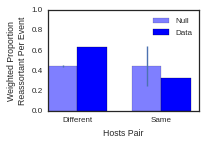

In [26]:
seaborn.set_context("paper")
seaborn.set_style('white')

fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(1,1,1)
ind = np.arange(2)
width = 0.35

ax.bar(ind, null.mean(), width, color='blue', label='Null', alpha=0.5, yerr=null.std()*5)
ax.bar(ind+width, data.mean(), width, color='blue', label='Data')
ax.set_xticks(ind+width)
ax.set_xticklabels(['Different', 'Same'])
ax.set_xlabel('Hosts Pair')
ax.set_ylabel('Weighted Proportion\nReassortant Per Event')
ax.legend()
ax.set_ylim(0,1)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.savefig('figures/Proportion Reassortant.pdf')